# Preliminaries - Installs, imports etc.

In [1]:
#@title Choose seed value
seed = 1995 #@param {type:"integer"}
!rm -rf ./logs/
%load_ext tensorboard
%matplotlib inline
import datetime
import numpy as np
from numpy.random import Generator, PCG64
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from IPython.display import clear_output

tf.random.set_seed(seed)  # Seeding Tensorflow.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#MNIST Dataset - Loading & Preprocessing

In [2]:
num_classes = 10
img_rows, img_cols, img_colors = 28, 28, 1  # Greyscale images of 28 X 28.

def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Attack Utils

##Fast Gradient Sign Method (FSGM)

In [3]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FastGradientSignMethod(model, images, labels, epsilon=0.3):

    # The GradientTape is the context at which we can explicitly ask for gradient calculation
    # We define the relevant tensors inside that context, and ask for the gradient calculation outside of it
    with tf.GradientTape() as grad:
      true_label_tensor = tf.Variable(labels, dtype=tf.float32)
      input_tensor = tf.Variable(images, dtype=tf.float32)
      predicted = model(input_tensor)
      adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.multiply(epsilon, tf.cast(tf.sign(adv_grads), dtype=tf.float32))
    adv_out = input_tensor + delta
    return adv_out.numpy()

## Evaluate Attack Success

In [4]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))

# Models For Attack

In [5]:
#@title Select The Model to Attack and Hyperparameters
selected_model = "CNN from Lecture 2" #@param ["CNN from Lecture 2", "NN from Ex 1", "Random Forest from Ex1"]
batch_size = 128 #@param {type:"integer"}
max_epochs = 12 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
lr_decay = 1e-6 #@param {type:"number"}
lr_drop = 20 #@param {type:"number"}

## CNN From Lecture 2

In [6]:
if selected_model == "CNN from Lecture 2":

  def lr_scheduler(epoch):
      return learning_rate * (0.5 ** (epoch // lr_drop))
  reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

  def build_mnist_model():    
    activation = 'relu'
    
    model = keras.Sequential(name = selected_model.replace(" ", "_"))
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

  lecture_model = build_mnist_model()

  lecture_model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(),
                metrics=[keras.metrics.CategoricalAccuracy()])
  callbacks_list = [tensorboard_callback, reduce_lr]
  attacked_model = lecture_model

  def train_model(epochs_num: int, train_inputs, train_outputs):
    history = attacked_model.fit(train_inputs, train_outputs,
        batch_size=batch_size,
        epochs=epochs_num,
        verbose=1,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history

## NN from Ex 1

In [7]:
if selected_model == "NN from Ex 1":
  nn_model = keras.models.Sequential([
    layers.Flatten(input_shape=(img_rows, img_cols, img_colors)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
    layers.Activation('softmax', name='y_pred')
  ], name = selected_model.replace(" ", "_"))

  nn_model.compile(
      optimizer=keras.optimizers.Adam(learning_rate),
      loss='categorical_crossentropy',
      metrics=[keras.metrics.CategoricalAccuracy()])
  callbacks_list = [tensorboard_callback]
  attacked_model = nn_model

  def train_model(epochs_num: int, train_inputs, train_outputs):
    history = attacked_model.fit(train_inputs, train_outputs,
        batch_size=batch_size,
        epochs=epochs_num,
        verbose=1,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history

## Random-Forest from Ex 1

In [8]:
# TODO: Consider if non NN model are even acceptable, or useful...
if selected_model == "Random Forest from Ex1":
  rforest = RandomForestClassifier(n_estimators=5, random_state=seed)
  x_train_flat = train_images.reshape(train_images.shape[0], -1)
  x_test_flat = test_images.reshape(test_images.shape[0], -1)
  y_train_digits = np.argmax(train_labels, axis=1)
  y_test_digits = np.argmax(test_labels, axis=1)

  def train_model(epochs_num: int, train_inputs, train_outputs):
    rforest.fit(x_train_flat, y_train_digits)
    y_pred = rforest.predict(x_test_flat)
    cmrforest = confusion_matrix(y_test_digits, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cmrforest ,annot=True , fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(f'Random Forest train-accuracy: {rforest.score(x_train_flat, y_train_digits)}')
    print(f'Random Forest test-accuracy: {rforest.score(x_test_flat, y_test_digits)}')

  attacked_model = rforest

## Train The Selected Model

In [9]:
try:
  attacked_model.summary()
except:
  pass

history = train_model(max_epochs, train_images, train_labels)
%tensorboard --logdir logs/fit

Model: "CNN_from_Lecture_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)        

Reusing TensorBoard on port 6006 (pid 215), started 1:58:21 ago. (Use '!kill 215' to kill it.)

<IPython.core.display.Javascript object>

# Re-training Defense Mechanism

In [19]:
#@title Attack Configuration
attacked_samples: int = 1000 #@param {type:"integer"}
epsilon: float = 0.3 #@param {type:"number"}
attack_iterations: int = 5 #@param {type:"integer"}
rng = Generator(PCG64(seed))

def perform_attack_and_evaluate(model, test_set, rng_gen):
  images_to_attack = test_set[rng_gen.integers(test_set.shape[0], size=attacked_samples)]
  attacked_labels = attacked_model.predict(images_to_attack)
  adv_images = FastGradientSignMethod(attacked_model, images_to_attack, attacked_labels, epsilon=epsilon)
  TestAttack(attacked_model, adv_images, images_to_attack, attacked_labels, targeted=False)
  return adv_images

def show_adv_image(attacked_model, adv_images, title: str=""):
  index = 10
  img = adv_images[index].reshape(img_rows, img_cols)
  plt.imshow(img)
  plt.title(title)
  plt.show()
  misclassified_label = np.argmax(attacked_model.predict(np.expand_dims(adv_images[index], axis=0)), axis=1)
  print(f'Mis-classified label: {misclassified_label}')


Test loss: 2.47
Successfully moved out of source class: 0.62
Mean perturbation distance: 0.30


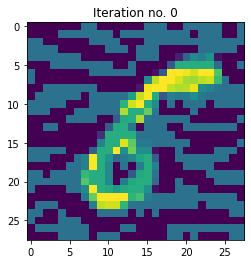

Mis-classified label: [8]
477/477 [==============================] - 3s 6ms/step - loss: 0.1451 - categorical_accuracy: 0.9574 - val_loss: 0.0657 - val_categorical_accuracy: 0.9794
Test loss: 2.80
Successfully moved out of source class: 0.67
Mean perturbation distance: 0.30


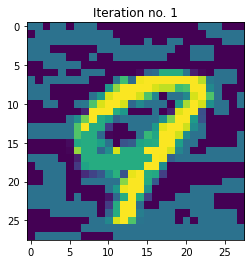

Mis-classified label: [7]
484/484 [==============================] - 3s 6ms/step - loss: 0.1528 - categorical_accuracy: 0.9563 - val_loss: 0.0646 - val_categorical_accuracy: 0.9796
Test loss: 2.64
Successfully moved out of source class: 0.61
Mean perturbation distance: 0.30


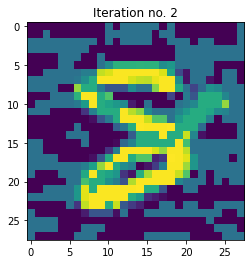

Mis-classified label: [3]
492/492 [==============================] - 3s 6ms/step - loss: 0.1570 - categorical_accuracy: 0.9554 - val_loss: 0.0625 - val_categorical_accuracy: 0.9809
Test loss: 2.51
Successfully moved out of source class: 0.65
Mean perturbation distance: 0.30


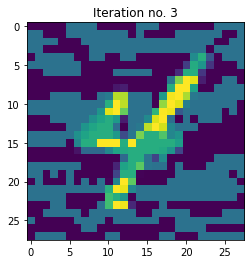

Mis-classified label: [4]
500/500 [==============================] - 3s 6ms/step - loss: 0.1646 - categorical_accuracy: 0.9531 - val_loss: 0.0616 - val_categorical_accuracy: 0.9810
Test loss: 2.29
Successfully moved out of source class: 0.62
Mean perturbation distance: 0.30


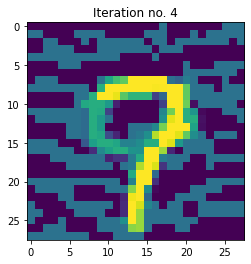

Mis-classified label: [7]
507/507 [==============================] - 3s 6ms/step - loss: 0.1713 - categorical_accuracy: 0.9511 - val_loss: 0.0594 - val_categorical_accuracy: 0.9818


In [20]:
updated_train_images = train_images.copy()
updated_train_labels = train_labels.copy()
for i in range(attack_iterations):
  adversarial_images = perform_attack_and_evaluate(attacked_model, test_images, rng)
  adversarial_labels = attacked_model.predict(adversarial_images)
  updated_train_images, unique_indices = np.unique(np.concatenate(
      [updated_train_images, adversarial_images], axis=0), axis=0, 
      return_index=True)
  updated_train_labels = np.concatenate(
      [updated_train_labels, adversarial_labels], axis=0)[unique_indices,:]
  #print(updated_train_images.shape)
  #print(updated_train_labels.shape)
  show_adv_image(attacked_model, adversarial_images, f"Iteration no. {i}")
  train_model(epochs_num=1, train_inputs=updated_train_images, 
              train_outputs=updated_train_labels)
